In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp transformers
!git clone https://github.com/ChaitaliV/generative-explanation;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.8 MB/s eta 0:00:00
Cloning into 'generative-explanation'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 152 (delta 30), reused 3 (delta 3), pack-reused 96
Receiving objects: 100% (152/152), 7.20 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Mon Dec  4 18:19:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
device

device(type='cuda')

In [47]:
df = pd.read_csv('generative-explanation/datasets/supervised_data.csv')
df.head()

,Unnamed: 0,text,label,explanation
0,0,"I run the machine for the jeans etc., which ar...",0.0,i
1,1,"Apart from this, sir, after doing normal work ...",0.0,i
2,2,"Sir, income is work in contract, Sir what happ...",0.0,i
3,3,Almost in a month - there is work according to...,0.0,i
4,4,my name is Sonu.,0.0,i


In [48]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop('explanation', axis=1, inplace=True)
df.head()

,text,label
0,"I run the machine for the jeans etc., which ar...",0.0
1,"Apart from this, sir, after doing normal work ...",0.0
2,"Sir, income is work in contract, Sir what happ...",0.0
3,Almost in a month - there is work according to...,0.0
4,my name is Sonu.,0.0


In [49]:
df.rename(columns = {'text':'english_text'}, inplace = True)
df.head()

,english_text,label
0,"I run the machine for the jeans etc., which ar...",0.0
1,"Apart from this, sir, after doing normal work ...",0.0
2,"Sir, income is work in contract, Sir what happ...",0.0
3,Almost in a month - there is work according to...,0.0
4,my name is Sonu.,0.0


In [50]:
type(df['label'][0])

numpy.float64

In [54]:
df = df.dropna()

In [56]:
df['label'] = df['label'].astype(int)

In [57]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.english_text.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.label.values

In [58]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print(tokenized_texts[0])
print (len(tokenized_texts[0]))

Tokenize the first sentence:
['[CLS]', 'i', 'run', 'the', 'machine', 'for', 'the', 'jeans', 'etc', '.', ',', 'which', 'are', 'made', 'of', 'their', 'loops', '.', '[SEP]']
19


In [59]:
#Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(len(input_ids[0]))
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(input_ids[0]))

19
128


In [60]:
#Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(type(input_ids))
train_ids = input_ids[0:-500]
train_label = labels[0:-500]
test_ids = input_ids[-500:]
test_label = labels[-500:]
train_attention_masks = attention_masks[0:-500]
test_attention_masks = attention_masks[-500:]
print(len(train_label))
print(len(test_attention_masks))
print(len(train_ids))

<class 'numpy.ndarray'>
4639
500
4639


In [61]:
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_ids, train_label,random_state = 2018, test_size = 0.1 )
train_masks, validation_masks, _, _ = train_test_split(train_attention_masks, train_ids,
                                             random_state=2018, test_size=0.1)

In [62]:
type(validation_masks)

list

In [63]:
#Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
print(type(train_inputs))

<class 'torch.Tensor'>


In [64]:
train_inputs.shape

torch.Size([4175, 128])

In [65]:
train_labels.shape

torch.Size([4175])

In [66]:
train_masks.shape

torch.Size([4175, 128])

In [67]:
# Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
print(len(train_inputs))
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

4175


In [68]:
# Bert Model Configuration
# Initializing a BERT bert-base-uncased style configuration
# Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers

from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
# This process will load only configuration and not the weights associated with the model
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [69]:
# Loading the Hugging Face Bert Uncased Base Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = nn.DataParallel(model)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [70]:
# Optimizer Grouped Parameters
# reference:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

In [71]:
# The Hyperparameters for the Training Loop

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0.1, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [72]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [75]:
# The Training Loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []
validation_loss_set = []
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  train_loss_set.append(tr_loss/nb_tr_steps)

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  validation_loss_set.append(eval_accuracy/nb_eval_steps)

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.6774042235023674


Epoch:  10%|█         | 1/10 [01:35<14:16, 95.21s/it]

Validation Accuracy: 0.7413793103448276
Train loss: 0.472671751346853


Epoch:  20%|██        | 2/10 [03:09<12:39, 94.95s/it]

Validation Accuracy: 0.728448275862069
Train loss: 0.2624858903673645


Epoch:  30%|███       | 3/10 [04:44<11:03, 94.84s/it]

Validation Accuracy: 0.7004310344827587
Train loss: 0.13371806434566205


Epoch:  40%|████      | 4/10 [06:19<09:28, 94.81s/it]

Validation Accuracy: 0.7112068965517241
Train loss: 0.07074732906666809


Epoch:  50%|█████     | 5/10 [07:54<07:54, 94.86s/it]

Validation Accuracy: 0.6961206896551724
Train loss: 0.04647987232618462


Epoch:  60%|██████    | 6/10 [09:29<06:19, 94.80s/it]

Validation Accuracy: 0.7155172413793104
Train loss: 0.033476871300499415


Epoch:  70%|███████   | 7/10 [11:03<04:44, 94.72s/it]

Validation Accuracy: 0.6875
Train loss: 0.028757319776510814


Epoch:  80%|████████  | 8/10 [12:38<03:09, 94.73s/it]

Validation Accuracy: 0.6896551724137931
Train loss: 0.02401303146230735


Epoch:  90%|█████████ | 9/10 [14:13<01:34, 94.73s/it]

Validation Accuracy: 0.6831896551724138
Train loss: 0.02136166489253113


Epoch: 100%|██████████| 10/10 [15:47<00:00, 94.78s/it]

Validation Accuracy: 0.6875


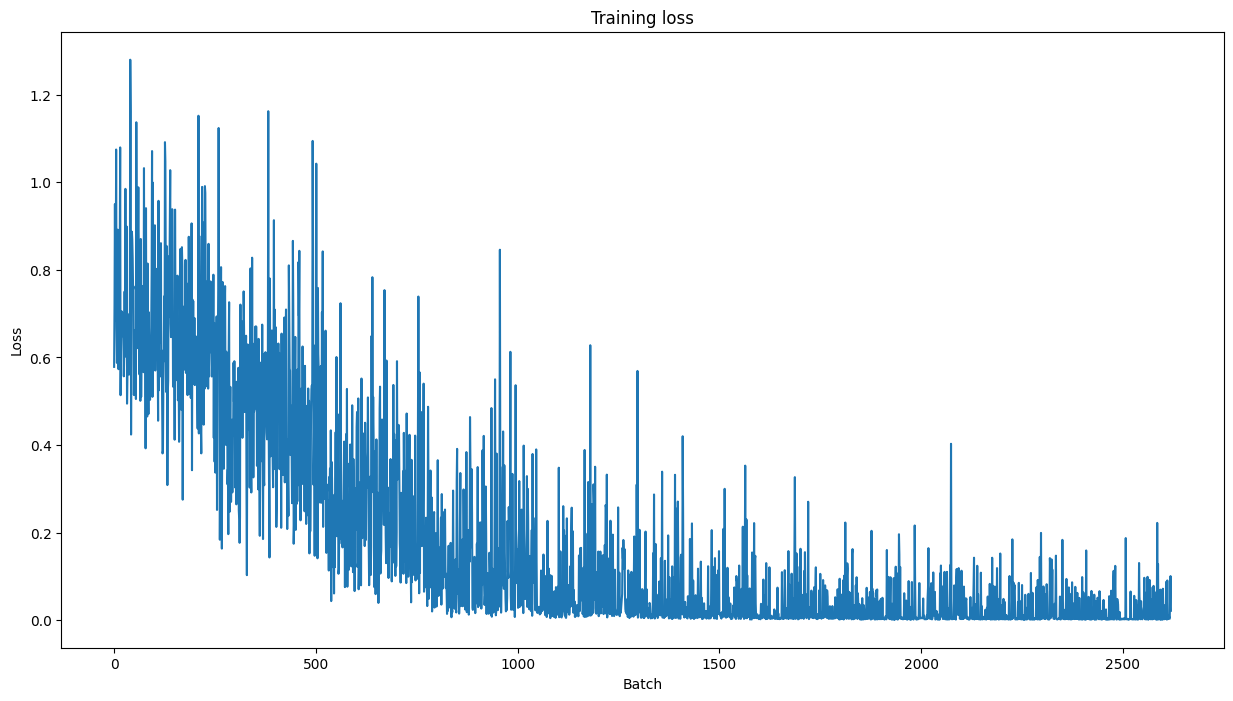

In [76]:
# Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [77]:
prediction_inputs = torch.tensor(test_ids)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_label)

batch_size = 32
print(len(test_ids))
print(len(test_attention_masks))
print(len(test_label))

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

500
500
500


In [78]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [79]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [81]:
#@title Score of Individual Batches
matthews_set

[-0.08304547985373997,
 0.6368213313263433,
 0.4123163955081219,
 0.6327138353044138,
 0.6150362734881881,
 0.43104098554421344,
 0.6191391873668903,
 0.6490341154506964,
 0.5944208630540292,
 0.8009640069195055,
 0.6630989401334365,
 0.6610073157437473,
 0.20614861915245739,
 0.19384952863381638,
 0.14766527713164573,
 0.4389849401280572]

In [80]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5006464619839217

In [83]:
torch.save(model,r'/content/drive/MyDrive/BERT_classification.pt')
